<a href="https://colab.research.google.com/github/bruno2siqueira/Machine_Learning/blob/main/v_2_Atividade_4_COVID_RS_Aprendizado_de_M%C3%A1quina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Atividade 4 - Aprendizado de Máquina: COVID-19**

* Por: Bruno Siqueira da Silva <<bruno.siqueira@inf.ufpel.edu.br>>

* O objetivo deste trabalho é utilizar e avaliar técnicas de aprendizado de máquina em uma base de dados real. Esta base é originada da Secretaria Estadual de Saúde do RS e contém todos casos registrados de COVID-19 no estado, com informações diversas sobre cada caso, incluindo informações de hospitalização e óbito.

* Observação: *Parte do código foi adaptada a partir dos notebooks apresentados pelo prof. Ricardo Araújo em aula.*

Abaixo as etapas do trabalho:

# 1 Preparação do ambiente

###1.1 Importação das bibliotecas



In [2]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from unicodedata import normalize
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Carregamento do arquivo

* O primeiro passo é baixar dados epidemiológicos da COVID-19 no Rio Grande do Sul, Secretaria Estadual de Saúde - SES.

* Disponível em: https://ti.saude.rs.gov.br/covid19/


####1.2.1 Fonte de dados obtidos da Secretaria Estadual de Saúde do RS

In [16]:
# Baixar os dados e renomear para algo mais usável 
# Como os dados são atualizados diariamente, uma boa ideia fazer uma cópia mais estável

!wget https://ti.saude.rs.gov.br/covid19/download
!mv download dados_covid_rs.csv  #disponibiliza no ambiente de produção

dados = pd.read_csv('/content/dados_covid_rs.csv', delimiter=';')

--2020-12-01 16:57:10--  https://ti.saude.rs.gov.br/covid19/download
Resolving ti.saude.rs.gov.br (ti.saude.rs.gov.br)... 200.198.173.170
Connecting to ti.saude.rs.gov.br (ti.saude.rs.gov.br)|200.198.173.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘download’

download                [    <=>             ]  64.55M  3.45MB/s    in 21s     

2020-12-01 16:57:33 (3.04 MB/s) - ‘download’ saved [67688432]



####1.2.2 Dando uma olhada se os dados foram carregados corretamente

Foram gerados 322.058 registros (linhas) e 29 colunas


In [4]:
dados

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,CONDICOES,GESTANTE,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Masculino,20 a 29,RT-PCR,04/11/2020,04/11/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,18/11/2020,BRANCA,NAO ENCONTRADO,SIM,DOM TIMOTEO,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Feminino,60 a 69,RT-PCR,06/11/2020,06/11/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,Doenças cardíacas crônicas,NAO,NaN,20/11/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Masculino,70 a 79,RT-PCR,06/11/2020,06/11/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,20/11/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Masculino,40 a 49,RT-PCR,04/11/2020,03/11/2020,NaN,RECUPERADO,NAO,SIM,SIM,NAO,NAO,SIM,NaN,NAO,NaN,17/11/2020,BRANCA,NAO ENCONTRADO,NAO,DOM TIMOTEO,NAO,E-SUS,BRASIL,NAO
4,430003,ACEGUÁ,16,BAGE - R22,Feminino,15 a 19,RT-PCR,06/11/2020,06/11/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,20/11/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322053,432380,XANGRI-LÁ,3,CAPAO DA CANOA - R04 R05,Feminino,80 e mais,TESTE RÁPIDO,16/08/2020,16/08/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,SIM,NaN,NAO,NaN,30/08/2020,BRANCA,NAO ENCONTRADO,NAO,CENTRO,NAO,E-SUS,BRASIL,NAO
322054,432380,XANGRI-LÁ,3,CAPAO DA CANOA - R04 R05,Masculino,20 a 29,TESTE RÁPIDO,20/08/2020,20/08/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,SIM,NaN,NAO,NaN,03/09/2020,BRANCA,NAO ENCONTRADO,NAO,ATLANTIDA,NAO,E-SUS,BRASIL,NAO
322055,432380,XANGRI-LÁ,3,CAPAO DA CANOA - R04 R05,Masculino,50 a 59,RT-PCR,07/08/2020,02/08/2020,NaN,RECUPERADO,NAO,SIM,NAO,NAO,NAO,SIM,NaN,NAO,NaN,16/08/2020,PRETA,NAO ENCONTRADO,NAO,RAINHA DO MAR,NAO,E-SUS,BRASIL,NAO
322056,432380,XANGRI-LÁ,3,CAPAO DA CANOA - R04 R05,Masculino,50 a 59,RT-PCR,10/08/2020,02/08/2020,NaN,RECUPERADO,NAO,SIM,NAO,SIM,NAO,SIM,NaN,NAO,NaN,16/08/2020,BRANCA,NAO ENCONTRADO,NAO,GUARA,NAO,E-SUS,BRASIL,NAO


# 2 Preparação dos dados

Nessa etapa, foi preciso converter os atributos categóricos para numéricos, ajustando o conteúdo dos atributos às restrições dos modelos utilizados no processo de Aprendizado de Máquina.

### 2.1 Tratando dados faltantes ou não-numéricos
Algumas colunas possuem "NaN" (Not a Number) ou "NaT" (Not a Time), indicando que são valores faltantes. Além disso, há colunas com tipos variados de registros, que não podem ser binarizados. 

*Ressalta-se que esta etapa considerou apenas dados potenciais utilizados no experimento.*



####2.1.1 Tratando colunas `FEBRE, TOSSE, GARGANTA, DISPNEIA e OUTROS`

As colunas `FEBRE, TOSSE, GARGANTA, DISPNEIA` foram consideradas pois podem ser considerados sintomas comuns da COVID-19. Sendo que a coluna `OUTROS` pode significar sintomas adicionais identificados durante a traigem do paciente. 

In [34]:
rows = []
for column in dados.columns:
  row = {'coluna': column, 'nans': dados[column].isnull().sum(), 'frac_nans': dados[column].isnull().sum() / dados.shape[0]}
  rows.append(row)
res = pd.DataFrame(rows)
res[res.nans>0].sort_values('nans', ascending=False)

,coluna,nans,frac_nans
19,DATA_INCLUSAO_OBITO,315244,0.978845
9,DATA_EVOLUCAO,300181,0.932074
17,CONDICOES,273475,0.849151
20,DATA_EVOLUCAO_ESTIMADA,36031,0.111878
27,PAIS_NASCIMENTO,11886,0.036907
22,ETNIA_INDIGENA,11532,0.035807
15,DISPNEIA,3755,0.011659
24,BAIRRO,2684,0.008334
12,FEBRE,20,0.000062
13,TOSSE,20,0.000062


**Observação importante**: Em relação a coluna `CONDICOES`, que potencialmente poderia ser utilizada para melhorar o desempenho do modelo, uma vez que pode indicar pacientes pertencentes a algum grupo de risco, inicialmente, não foi considerado, pois o percentual de regitros faltantes dessa coluna é na ordem de 84%. Isso pode resultar na inserção de dados ruídosos e provocar o desbalanceamento nos modelos caso estes estes forem considerados.

a) Tratando a coluna `DISPNEIA`, com cerca de 1% dos valores faltantes, preenchendo com valores aleatórios, mas que seguem a distribuição dos dados.

In [35]:
dist = dados["DISPNEIA"].value_counts(normalize=True)
faltantes = dados['DISPNEIA'].isnull()
dados.loc[faltantes,'DISPNEIA'] = np.random.choice(dist.index, size=len(dados[faltantes]), p=dist.values)

# Testando para ver se não há mais valores faltantes
dados["DISPNEIA"].isnull().any()

False

b) Tratando a coluna `FEBRE`, preenchendo os dados faltantes com valores aleatórios.

In [36]:
dist = dados["FEBRE"].value_counts(normalize=True)
faltantes = dados['FEBRE'].isnull()
dados.loc[faltantes,'FEBRE'] = np.random.choice(dist.index, size=len(dados[faltantes]), p=dist.values)

# Testando para ver se não há mais valores faltantes
dados["FEBRE"].isnull().any()

False

c) Tratando a coluna `TOSSE`, preenchendo os dados faltantes com valores aleatórios.

In [37]:
dist = dados["TOSSE"].value_counts(normalize=True)
faltantes = dados['TOSSE'].isnull()
dados.loc[faltantes,'TOSSE'] = np.random.choice(dist.index, size=len(dados[faltantes]), p=dist.values)

# Testando para ver se não há mais valores faltantes
dados["TOSSE"].isnull().any()

False

d) Tratando a coluna `GARGANTA`, preenchendo os dados faltantes com valores aleatórios

In [38]:
dist = dados["GARGANTA"].value_counts(normalize=True)
faltantes = dados['GARGANTA'].isnull()
dados.loc[faltantes,'GARGANTA'] = np.random.choice(dist.index, size=len(dados[faltantes]), p=dist.values)

# Testando para ver se não há mais valores faltantes
dados["GARGANTA"].isnull().any()

False

e) Tratando a coluna `OUTROS`, preenchendo os dados faltantes com valores aleatórios

In [39]:
dist = dados["OUTROS"].value_counts(normalize=True)
faltantes = dados['OUTROS'].isnull()
dados.loc[faltantes,'OUTROS'] = np.random.choice(dist.index, size=len(dados[faltantes]), p=dist.values)

# Testando para ver se não há mais valores faltantes
dados["OUTROS"].isnull().any()

False

####2.1.2 Tratando coluna `PROFISSIONAL_SAUDE`, com registros SIM, NAO e NAO INFORMADO 

Optou-se por esta coluna, considerando que os `Profissionais da Saúde` são indivíduos que circulam em espaços onde é realizado o atendimento de pacientes infectados, com isso, podem ter maior chances de serem infectados.

In [40]:
dados['PROFISSIONAL_SAUDE']

0         NAO
1         NAO
2         NAO
3         NAO
4         NAO
         ... 
322052    NAO
322053    NAO
322054    NAO
322055    NAO
322056    NAO
Name: PROFISSIONAL_SAUDE, Length: 322057, dtype: object

Transformando dados categóricos para dados binários. Para todo campo igual a `SIM`, é atribuído 1, caso contrário, passa a valer 0. 

O mesmo foi realizado com a coluna `PES_PRIV_LIBERDADE`, por considerar este campo de indivídos 'presos privados de liberdade' pertencem a um grupo com potencial risco de contaminação.

In [41]:
dados["PROFISSIONAL_SAUDE"] = dados["PROFISSIONAL_SAUDE"].apply(lambda x: '1' if x=='SIM' else '0')

# Testando para ver se não há mais valores faltantes
dados["PROFISSIONAL_SAUDE"].isnull().any()

False

In [42]:
dados["PES_PRIV_LIBERDADE"] = dados["PES_PRIV_LIBERDADE"].apply(lambda x: '1' if x=='SIM' else '0')

# Testando para ver se não há mais valores faltantes
dados["PES_PRIV_LIBERDADE"].isnull().any()

False

Até aqui, não houveram transformações significativas nos dados originais, apenas foram tratados dados faltantes (que foram binarizados), e não foram criadas novas colunas.

####2.1.3. Tratando coluna `FAIXA_ETARIA`

Com a inclusão dos dados da coluna `FAIXA_ETARIA`, é preciso aplicar uma engenharia de atributos, uma vez que os dados precisam ser corretamente ajustados para que os modelos possam utilizar os dados. Para isso, o utilitário LabelBinalizer foi utilizado, e na sequência, foi gerada uma coluna para cada `FAIXA_ETARIA` contida no conjunto de dados, contabilizando 12 categorias de `FAIXA_ETARIA`

In [43]:
codFe = LabelBinarizer()
codFe.fit(dados['FAIXAETARIA'])
atributo_transformado = codFe.transform(dados['FAIXAETARIA'])

onehot = pd.DataFrame(atributo_transformado)
onehot.columns = codFe.classes_
dados = pd.concat([dados, onehot], axis=1).drop(['FAIXAETARIA'], axis=1)

In [44]:
#dando mais uma olhada nos dados
dados.head()

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,CONDICOES,GESTANTE,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE,01 a 04,05 a 09,10 a 14,15 a 19,20 a 29,30 a 39,40 a 49,50 a 59,60 a 69,70 a 79,80 e mais,<1
0,430003,ACEGUÁ,16,BAGE - R22,Feminino,RT-PCR,09/11/2020,06/11/2020,NaN,RECUPERADO,NAO,NAO,SIM,NAO,NAO,NAO,NaN,NAO,NaN,20/11/2020,BRANCA,NAO ENCONTRADO,0,ZONA RURAL,NAO,E-SUS,BRASIL,0,0,0,0,0,1,0,0,0,0,0,0,0
1,430003,ACEGUÁ,16,BAGE - R22,Masculino,RT-PCR,09/11/2020,06/11/2020,NaN,RECUPERADO,NAO,NAO,SIM,NAO,NAO,NAO,NaN,NAO,NaN,20/11/2020,BRANCA,NAO ENCONTRADO,0,ZONA RURAL,NAO,E-SUS,BRASIL,0,0,0,0,0,1,0,0,0,0,0,0,0
2,430003,ACEGUÁ,16,BAGE - R22,Feminino,RT-PCR,05/10/2020,29/09/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,13/10/2020,BRANCA,NAO ENCONTRADO,0,ZONA RURAL,NAO,E-SUS,BRASIL,0,0,0,0,0,0,0,1,0,0,0,0,0
3,430003,ACEGUÁ,16,BAGE - R22,Masculino,RT-PCR,06/10/2020,06/10/2020,NaN,RECUPERADO,NAO,NAO,NAO,NAO,NAO,NAO,NaN,NAO,NaN,20/10/2020,BRANCA,NAO ENCONTRADO,0,ZONA RURAL,NAO,E-SUS,BRASIL,0,0,0,0,1,0,0,0,0,0,0,0,0
4,430003,ACEGUÁ,16,BAGE - R22,Feminino,RT-PCR,11/09/2020,08/09/2020,NaN,RECUPERADO,NAO,SIM,NAO,SIM,NAO,NAO,Gestante,SIM,NaN,22/09/2020,BRANCA,NAO ENCONTRADO,0,DOM TIMOTEO,NAO,E-SUS,BRASIL,0,0,0,0,0,1,0,0,0,0,0,0,0


##2.2 Tranformando valores de String para Valores numéricos

Abaixo são tratados as colunas que ainda não foram binarizadas, para formar o conjunto de dados de dados utilizados pelos modelos nesse experimento.

In [45]:
#Problemas de ML trabalham melhor com dados numéricos

dados["SEXO"]= dados["SEXO"].apply(lambda x: '1' if x=='Masculino' else '0')
dados["GESTANTE"]= dados["GESTANTE"].apply(lambda x: '1' if x=='SIM' else '0')
dados["FEBRE"]= dados["FEBRE"].apply(lambda x: '1' if x=='SIM' else '0')
dados["GARGANTA"]= dados["GARGANTA"].apply(lambda x: '1' if x=='SIM' else '0')
dados["TOSSE"]= dados["TOSSE"].apply(lambda x: '1' if x=='SIM' else '0')
dados["DISPNEIA"]= dados["DISPNEIA"].apply(lambda x: '1' if x=='SIM' else '0')
dados["OUTROS"] = dados["OUTROS"].apply(lambda x: '1' if x=='SIM' else '0')
dados["HOSPITALIZADO"]= dados["HOSPITALIZADO"].apply(lambda x: '1' if x=='SIM' else '0')

#Fitro com dados definidos como importantes para o modelo
dados = dados[['SEXO', 'GESTANTE', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 
               '01 a 04',	'05 a 09',	'10 a 14',	'15 a 19',	'20 a 29',	'30 a 39', '40 a 49',	'50 a 59',	'60 a 69',	'70 a 79',	'80 e mais',	'<1',
               'OUTROS','PROFISSIONAL_SAUDE', 'PES_PRIV_LIBERDADE', 'HOSPITALIZADO']].reset_index(drop=True)

print ("Valores ajustados e atributos considerados selecionados!\n")
dados

Valores ajustados e atributos considerados selecionados!



,SEXO,GESTANTE,FEBRE,TOSSE,GARGANTA,DISPNEIA,01 a 04,05 a 09,10 a 14,15 a 19,20 a 29,30 a 39,40 a 49,50 a 59,60 a 69,70 a 79,80 e mais,<1,OUTROS,PROFISSIONAL_SAUDE,PES_PRIV_LIBERDADE,HOSPITALIZADO
0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
322053,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
322054,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
322055,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0



#3 Treinamento




###3.1 Conferindo total de registros de acordo com o atributo alvo: HOSPITALIZADO 

In [46]:
dados['HOSPITALIZADO']= dados['HOSPITALIZADO'].astype(int)
nhosp = (dados['HOSPITALIZADO'].count()) -(dados['HOSPITALIZADO'].sum())
print ("Total de registros: ", dados['HOSPITALIZADO'].count(), 
       "\nNão Hospitalizados: ", nhosp,
       "\nHospitalizados....: ", dados['HOSPITALIZADO'].sum())

Total de registros:  322057 
Não Hospitalizados:  297900 
Hospitalizados....:  24157


###3.2 Dividindo os dados em treino e teste

O método `train_test_split` será utilizado para separação dos conjuntos, considerando 20% de dados de teste


In [47]:
from sklearn.model_selection import train_test_split # Separa dados de treinamento e teste

treino, teste = train_test_split(dados, test_size=0.2)
print("Treino:", len(treino)) 
print("Teste.:", len(teste)) 

Treino: 257645
Teste.: 64412


In [48]:
# Carregando os atributos e classes dos dados de treino
X_treino = treino.drop('HOSPITALIZADO', axis='columns')
y_treino = treino['HOSPITALIZADO']

# Carregando os atributos e classes dos dados de teste
X_teste = teste.drop('HOSPITALIZADO', axis='columns')
y_teste = teste['HOSPITALIZADO']

###3.3 Modelos selecionados

**... vamos começar o treinamento**

Foram utilizados os modelos de classificação abaixo para prever o valor da variável destino:


> 3.3.1. Árvore de Decisão (Decision Tree)

> 3.3.2. Random Forest

> 3.3.3. Classificador de Regressão Logística

Na sequência, segue a aplicação dos modelos selecionados e a sua avaliação.

#####3.3.1 Treinando com Árvores de decisão (Decision Tree)

Este método de aprendizado supervisionado não paramétrico é usado para classificação e regressão, que aprende a partir de regras de decisão simples inferidas dos recursos de dados.

In [49]:
# DecisionTreeClassifier é uma classe capaz de realizar classificação multiclasse em um conjunto de dados.
from sklearn.tree import DecisionTreeClassifier  # Modelo utilizado

modelo = DecisionTreeClassifier(random_state=0, criterion="entropy")

# A função fit recebe como primeiro parâmetro uma matriz CxN, com C colunas e N linhas, onde cada linha especifica um exemplo
# O segundo parâmetro é um vetor com N posições, indicando os rótulos das linhas da matriz no primeiro parâmetro
modelo_treinado = modelo.fit(X_treino, y_treino)

**Avaliação do modelo**

Com o modelo treinado, temos que avaliá-lo no conjunto de teste. O sklearn implementa boa parte das métricas, bem como permite mostrar a matriz de confusão completa. Alguns dos módulos do sklearn são acrescentados para comparar os modelos.

In [50]:
from sklearn.metrics import accuracy_score # Metricas para calcular accuracy score

# Passamos os exemplos sem classe pelo primeiro modelo treinado, que retorna a predicao em um vetor
predicoes = modelo_treinado.predict(X_teste)

# Com as predicoes, podemos calcular as métricas. Abaixo, a acurácia.
acuracia = accuracy_score(y_teste, predicoes) # Observe que sempre passamos os valores verdadeiros (y_teste) e depois as predicoes
print("Acurácia do modelo: ", f"{acuracia:.1%}")
print("Acurácia do modelo diz quanto o modelo acertou das previsões possíveis")

Acurácia do modelo:  94.7%
Acurácia do modelo diz quanto o modelo acertou das previsões possíveis


> **Matriz de Confusão**

1. A métrica `precision` identifica qual a proporção de identificações positivas foi realmente correta. Em outras palavras, o qual bem meu modelo trabalhou.

2. A métrica `recall` identifica qual a proporção de positivos foram identificados corretamente. Ou seja, avalia o quão bom meu modelo é para prever positivos, sendo positivo entendido como a classe que se quer prever, no nosso contexto, se é um indivíduo não hospitalizado.

3. A métrica `f1-score` mostra o balanço entre a `precision` e o `recall` do  modelo.



In [51]:
from sklearn.metrics import classification_report

# 0 para NAO HOSPTALIZADO, 1 para HOSPTALIZADO
relatorio = classification_report(y_teste, predicoes)
print(relatorio)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     59733
           1       0.69      0.47      0.56      4679

    accuracy                           0.95     64412
   macro avg       0.83      0.73      0.77     64412
weighted avg       0.94      0.95      0.94     64412



O modelo apresentou precisão de **96%** para os casos que não demandam hospitalização '**0**', considerado melhor para os casos que demandam de hospitalização '**1**', que apresentou precisão de **69%**. Com a matriz de confusão, acurácia obtida foi de **95%**. 

Assim, este modelo:

Previu `NAO HOSPITALIZADO` **98%** corretamente

Previu `HOSPITALIZADO` **47%** corretamente

Previu `NAO HOSPITALIZADO` **1%** incorretamente

Previu `HOSPITALIZADO` **53%** incorretamente


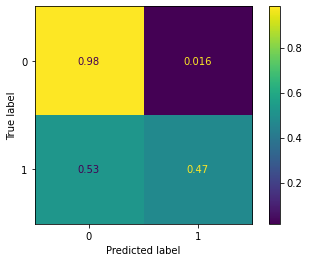

In [52]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(modelo_treinado, X_teste, y_teste, normalize='true')

> **Análise de desempenho do modelo**

ROC é uma curva de probabilidade. Ela é criada traçando a taxa `verdadeiro-positivo` contra a taxa de `falsos-positivos`. Ou seja, número de vezes que o classificador acertou a predição conta o número de vezes que o classificador errou a predição.

O AUC representa o grau ou medida de separabilidade. Quanto maior o AUC, melhor o modelo está em prever 0s como 0s e 1s como 1s. Por exemplo, quanto maior a AUC, melhor o modelo está em distinguir entre pacientes com doença e pacientes sem doença

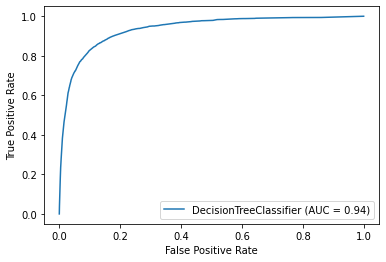

In [53]:
from sklearn.metrics import plot_roc_curve # recurso para imprimir a curva ROC e AUC 
plot_roc_curve(modelo_treinado, X_teste, y_teste)

> **Método Bootstrapping**

A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo. É amplamente empregada em problemas onde o objetivo da modelagem é a predição. Busca-se então estimar o quão preciso é este modelo na prática, ou seja, o seu desempenho para um novo conjunto de dados.

In [54]:
from sklearn.model_selection import ShuffleSplit

# Vamos criar 10 separações (considerado o padrão), mantendo 20% de teste em cada uma
rs = ShuffleSplit(n_splits=10, test_size=.2)

X = dados.drop('HOSPITALIZADO', axis='columns')
y = dados['HOSPITALIZADO']

# Array para armazernamos as acurácias de cada modelo
acuracias = []

Agora iteramos por cada separação e treinamos o modelo

In [55]:
# O método split retorna índices para o vetor passado como parametro
# O .loc é a maneira de indexar tabelas no pandas a partir de índices
for train_index, test_index in rs.split(X):
  modelo_treinado = modelo.fit(X.loc[train_index], y.loc[train_index])
  predicoes = modelo_treinado.predict(X.loc[test_index])
  acuracias.append(accuracy_score(y.loc[test_index], predicoes))

print(acuracias)
print("Média das acurácias: ", f"{sum(acuracias) / len(acuracias):.1%}")
#Uma abordagem seria estratificar a separação entre treino/teste. 
#A estratificação procura garantir que a distribuição dos dados é semelhante entre os grupos. 
#Ela pode ser feita tanto para atributos como para rótulos. 


[0.9459106998695895, 0.9460349003291312, 0.9466869527417251, 0.9447152704465006, 0.9451189219400111, 0.9467024777991678, 0.9444823945848599, 0.9445134446997454, 0.9461901509035583, 0.9444668695274172]
Média das acurácias:  94.5%


O resultado acima representa a pontuação média do modelo que é avaliada a partir das médias dos valores de cada interação. A acurácia média obtida se manteve equivalente ao produzido pelo SKLearn: **94,5%.**

> **3.3 K-Fold**

O Cross Validation serve para ajudar nessa validação do modelo. A validação cruzada *k-fold*, embaralha os dados separando-os em *k* partições, onde cada uma passa pelo treinamento contendo dados distintos. Nesse experimento, houve um divisão em 10 partes, com isso haverá 10 resultados no final, a media deles é a métrica de eficiência do modelo.

In [56]:
from sklearn.model_selection import cross_val_score

# O parâmetro cv indica quantas partições criaremos
scores = cross_val_score(modelo, X, y, cv=10)
print("Acurácia média: ", f"{scores.mean():.1%}")

Acurácia média:  94.5%


####3.1.2 Treinando com Randon Forest

O algoritmo Random Forest é um tipo de *ensemble learning*, método que gera muitos classificadores e combina o seu resultado. No caso do Random Forest, ele gera vários *decision trees*, cada um com suas particularidades e combinada o resultado da classificação de todos eles.

In [58]:
from sklearn.ensemble import RandomForestClassifier
modelo2 = RandomForestClassifier(max_depth=10, random_state=0)
modelo_treinado2 = modelo2.fit(X_treino, y_treino)

Avaliando desempenho do modelo

>*Para facilitar a exibição dos resultados, foi definida uma função chamada `resultado_modelo`.*

In [59]:
def resultado_modelo(modelo_treinado, X_teste, y_teste):
    predicoes = modelo_treinado.predict(X_teste)
    acuracia = accuracy_score(y_teste, predicoes)
    print("Acurácia do modelo: ", f"{acuracia:.1%}")

    relatorio = classification_report(y_teste, predicoes)
    print(relatorio)

    plot_confusion_matrix(modelo_treinado, X_teste, y_teste, normalize="true")

    plot_roc_curve(modelo_treinado, X_teste, y_teste)

Acurácia do modelo:  93.4%
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     59587
           1       0.60      0.36      0.45      4825

    accuracy                           0.93     64412
   macro avg       0.78      0.67      0.71     64412
weighted avg       0.92      0.93      0.93     64412



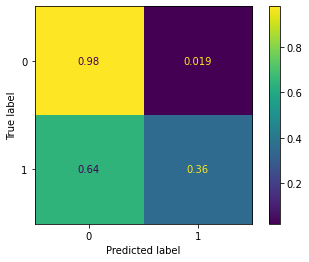

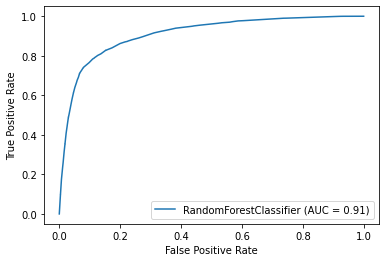

In [28]:
resultado_modelo(modelo_treinado2, X_teste, y_teste)

Avaliando desempenho do modelo

####3.1.3 Treinando com Classificador de Regressão Logística

Este algoritmo encontra um modelo de regressão que calcula a probabilidade de um dado ponto ter classificação 0 ou 1 (que chamaremos também de classificações negativa e positiva, respectivamente)

In [60]:
from sklearn.linear_model import LogisticRegression
modelo3 = LogisticRegression(random_state=0, max_iter=1000)
modelo_treinado3 = modelo3.fit(X_treino, y_treino)

Avaliando o modelo



Acurácia do modelo:  94.6%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     59733
           1       0.69      0.47      0.56      4679

    accuracy                           0.95     64412
   macro avg       0.82      0.73      0.76     64412
weighted avg       0.94      0.95      0.94     64412



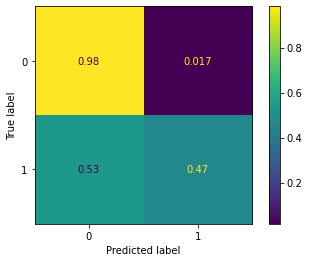

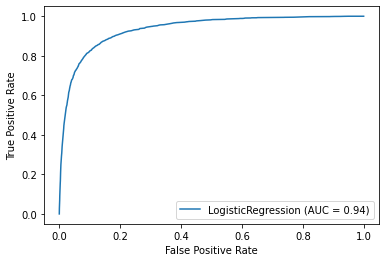

In [61]:
resultado_modelo(modelo_treinado3, X_teste, y_teste)

#4 Considerações preliminares

Para o conjunto de dados analisados, as técnicas utilizadas para treinamento, teste e validação, apresentaram resultados muito próximos, com acurácia entre 93% e 95%. Tendo como atributo alvo a necessidade de hospitalização do paciente 'HOSPITALIZADO'. 

Os demais atributos selecionados nesta análise foram oportunos e ajudaram na precisão do modelo. 

Já atributos relacionados a condições, região e evolução do quadro do paciente foram descartados, visto que em testes preliminares a correlação foi fraca ou haviam muitos dados faltantes. 

Com o modelo treinado, podemos testar com dados fictícios:

In [65]:
inferencia = modelo_treinado.predict([[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) # Árvore de Decisão
print ("Com DISPNEIA")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO") 

Com DISPNEIA
HOSPITALIZADO


In [66]:
inferencia = modelo_treinado2.predict([[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) # Randon Forest
print ("Com DISPNEIA")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO")

Com DISPNEIA
NAO HOSPITALIZADO


In [67]:
inferencia = modelo_treinado3.predict([[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) # Regressão Logística
print ("Com DISPNEIA")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO")

Com DISPNEIA
NAO HOSPITALIZADO


In [75]:
inferencia = modelo_treinado3.predict([[0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) # Regressão Logística
print ("Com FEBRE e DISPNEIA")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO") 

Com FEBRE e DISPNEIA
NAO HOSPITALIZADO


In [72]:
inferencia = modelo_treinado3.predict([[0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) # Regressão Logística
print ("Com FEBRE, TOSSE e DISPNEIA")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO") 

Com FEBRE, TOSSE e DISPNEIA
HOSPITALIZADO


In [76]:
inferencia = modelo_treinado3.predict([[0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) # Regressão Logística
print ("Com FEBRE, TOSSE, GARGANTA e DISPNEIA")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO") 

Com FEBRE, TOSSE, GARGANTA e DISPNEIA
NAO HOSPITALIZADO


In [79]:
inferencia = modelo_treinado.predict([[0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]) #àrvore de decisão
print ("Com FEBRE, TOSSE, GARGANTA, DISPNEIA e PROFISSIONAL_SAUDE")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO") 

Com FEBRE, TOSSE, GARGANTA, DISPNEIA e PROFISSIONAL_SAUDE
NAO HOSPITALIZADO


In [86]:
inferencia = modelo_treinado2.predict([[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
print ("Com FEBRE, TOSSE, GARGANTA, DISPNEIA, PROFISSIONAL_SAUDE e OUTROS")
if inferencia == 0 : 
  print ("NAO HOSPITALIZADO") 
else: 
  print ("HOSPITALIZADO") 

Com FEBRE, TOSSE, GARGANTA, DISPNEIA, PROFISSIONAL_SAUDE e OUTROS
NAO HOSPITALIZADO


Com as inferência acima, é possível verificar que a presença de `DISPNEIA` no modelo de classificação Árvore de Decisão, correspondendo ao valor mais determinante para a hospitalização do paciente. Para o modelo de classificação de Regressão Logistica, a combinação `FEBRE, TOSSE e DISPNEIA` resultam na combinação para hospitalização. O modelo de classificação Randon Forest, que apresentou a menor acurácia entre os três modelos avaliados, não apresentou um resultado igual ou parecido com os dois anteriores.